# ÇİÇEK TÜRLERİNİ TAHMİN ETME MODELLERİ GELİŞTİRME

# 1-GEREKLİ KÜTÜPHANELERİN YÜKLENMESİ 

In [1]:
import os  #dosya işlemleri için
import gc  #cpu,ram şişmesin diye gereksiz değişkenleri vs. kalıcı silmeyi sağlıyor
import cv2
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow import keras
from PIL import Image #Resimleri görmek için gerekli kütüphane (Pillow)
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split #Train verisini Train ve Validasyon olarak bölmek için
from tensorflow.keras.preprocessing.image import ImageDataGenerator #Veri çoğaltma için
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Activation, Flatten, Dense, Dropout
import random


2025-09-26 13:42:16.553905: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758894136.917706      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758894137.020081      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_dir = '/kaggle/input/flowers-dataset/'

test_dir  = os.path.join(base_dir, 'test')
train_dir = os.path.join(base_dir, 'train')

for d in [train_dir, test_dir]:
    print(d, "->", os.listdir(d)[:6]) 

/kaggle/input/flowers-dataset/train -> ['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']
/kaggle/input/flowers-dataset/test -> ['Image_747.jpg', 'Image_561.jpg', 'Image_345.jpg', 'Image_844.jpg', 'Image_270.jpg', 'Image_526.jpg']


Yukarıda yazdığımız kod parçasına göre dosya yapımız hakkında bilgi sahibi olabiliriz. flowers-dataset klasörünün içinde test ve train adında iki ayrı klasör var ve test klasörünün içerisinde .jpg uzantılı resimlerin olduğunu görüyoruz. Ancak train klasörü içerisinde 5 ayrı klasörün olduğunu ve bu klasörlerin isimlerinin bizim labelımız olduğunu görüyoruz.

In [3]:
img_size = (160, 160) # daha küçük resimler daha hızlı, doğruluk için arttırılabilir

# 2-VERİ SETİNİ YÜKLEME VE İNCELEME

Ayarlamaları tamamladığımıza göre sıradaki aşama train veri setindeki verileri alma:

In [4]:
labels = ['dandelion', 'daisy', 'sunflower', 'tulip', 'rose']

#Verileri getirmek için kullanılan bir fonksiyon yazıyoruz.
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num=labels.index(label) #labelları indexliyoruz
        for img in tqdm(os.listdir(path)):
            try:
                img_path = os.path.join(path, img)
            
                #goruntuyu oku ve isle                
                img_arr = cv2.imread(img_path, cv2.IMREAD_COLOR)
                if img_arr is None:
                    continue
                img_arr = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)

                # Yeniden boyutlandır
                resized_arr = cv2.resize(img_arr, img_size)

                # Normalize et
                resized_arr = resized_arr.astype("float32") / 255.0
                
                # Listeye ekle
                data.append([resized_arr, class_num])

            except Exception as e:
                print("Error:", img, e)

    return np.array(data, dtype=object)

#test verisinin labelları belli olmadığı için ayrı bir fonksiyon tanımlıyorum.
def get_testing_data(data_dir):
    data=[]
    for img_name in tqdm(os.listdir(data_dir)):
        img_path = os.path.join(data_dir, img_name)
        try:
            # resmi oku (renkli-IMREAD_COLOR)
            img = cv2.imread(img_path, cv2.IMREAD_COLOR)
            if img is None:   # bozuk dosya varsa atla
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
            # yeniden boyutlandır
            img = cv2.resize(img, img_size)
    
            # normalize
            img = img.astype("float32") / 255.0
    
            # data listesine ekle
            data.append(img)

        except Exception as e:
            print("Hata:", img_path, e)

    # numpy array'e çevir ve return et
    return np.array(data, dtype=object)

In [5]:
train_data = get_training_data(train_dir) #verileri getir
X_train = [] #görseller için
Y_train = [] #labellar için

for features, label in train_data:
    X_train.append(features)
    Y_train.append(label)

X_train = np.array(X_train) 
Y_train = np.array(Y_train)

#Görseller renkli olduğu için
X_train = X_train.reshape(-1, img_size[0], img_size[1], 3)  # 3 kanal (RGB)

100%|██████████| 497/497 [00:06<00:00, 73.51it/s]


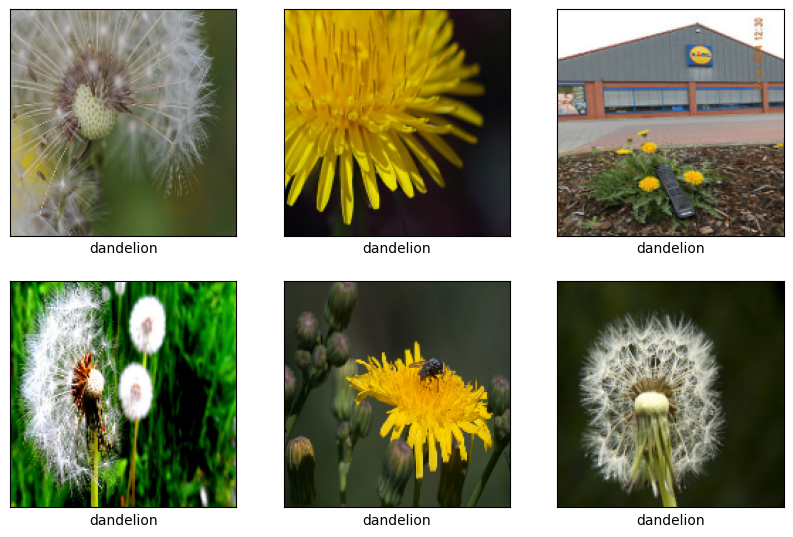

In [6]:
# İlk 6 resmi gösterelim
plt.figure(figsize=(10, 10))
for i in range(6):
    plt.subplot(3, 3, i+1)
    plt.xticks([]); plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i]) #resimler renkli olduğu için direkt bu kodu yazabiliriz
    plt.xlabel(labels[Y_train[i]])
plt.show()

In [7]:
count = daisy = dandelion = rose = sunflower = tulip = 0
resim_sayilari = {} #Resimlerin sınıfını ve kaç tane olduğunu içeren boş bir dictionary oluşturdum.

for root, dirs, files in os.walk("/kaggle/input/flowers-dataset/train"):
    klasor_adi = os.path.basename(root)
    
    for file in files:
        if file.endswith(".jpg") or file.endswith(".png"):
            count += 1
            if "daisy" in klasor_adi.lower():
                daisy +=1
            if "dandelion" in klasor_adi.lower():
                dandelion +=1
            if "rose" in klasor_adi.lower():
                rose +=1
            if "sunflower" in klasor_adi.lower():
                sunflower +=1
            if "tulip" in klasor_adi.lower():
                tulip +=1
for labelName in labels:
    if labelName == "daisy":
        resim_sayilari[labelName]=daisy
    if labelName == "dandelion":
        resim_sayilari[labelName]=dandelion
    if labelName == "rose":
        resim_sayilari[labelName]=rose
    if labelName == "sunflower":
        resim_sayilari[labelName]=sunflower
    if labelName == "tulip":
        resim_sayilari[labelName]=tulip

print("Train toplam resim sayısı:", count)
print("Daisy kategorisindeki toplam resim sayısı:", daisy)
print("Dandelion kategorisindeki toplam resim sayısı:", dandelion)
print("Rose kategorisindeki toplam resim sayısı:", rose)
print("Sunflower kategorisindeki toplam resim sayısı:", sunflower)
print("Tulip kategorisindeki toplam resim sayısı:", tulip)

print(resim_sayilari)

Train toplam resim sayısı: 2746
Daisy kategorisindeki toplam resim sayısı: 501
Dandelion kategorisindeki toplam resim sayısı: 646
Rose kategorisindeki toplam resim sayısı: 497
Sunflower kategorisindeki toplam resim sayısı: 495
Tulip kategorisindeki toplam resim sayısı: 607
{'dandelion': 646, 'daisy': 501, 'sunflower': 495, 'tulip': 607, 'rose': 497}


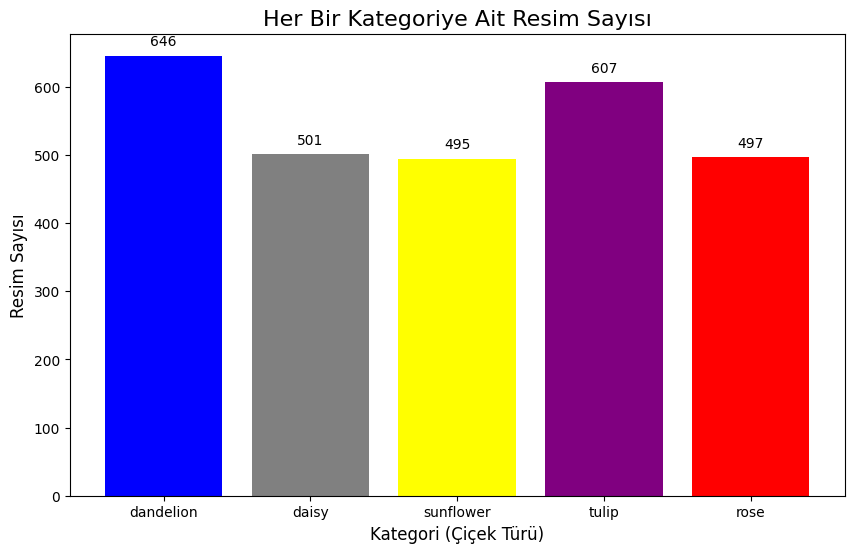

13431

In [8]:
# Sözlükteki anahtarları ve değerleri alıp parametre olarak vermeye hazır hale getirelim.
kategoriler = list(resim_sayilari.keys())
sayilar = list(resim_sayilari.values())

# Grafiğin boyutlarını ayarlayalım.
plt.figure(figsize=(10, 6))

# Çubuk grafiği oluşturma
plt.bar(kategoriler, sayilar, color=['blue', 'grey', 'yellow', 'purple', 'red'])

# Grafiğe başlık ve eksenlere etiket ekleme.
plt.title('Her Bir Kategoriye Ait Resim Sayısı', fontsize=16)
plt.xlabel('Kategori (Çiçek Türü)', fontsize=12)
plt.ylabel('Resim Sayısı', fontsize=12)

# Çubukların üzerine sayıları yazdırma.
for i in range(len(kategoriler)):
    plt.text(i, sayilar[i] + 15, sayilar[i], ha='center')

# Grafiği ekranda göster
plt.show()

# Ram,Cpu şişmesin diye kullanımını bitirdiğim değişkenleri vs. siliyorum.
del sunflower,daisy,dandelion,rose,tulip
resim_sayilari.clear()
del resim_sayilari
kategoriler.clear()
sayilar.clear()
del kategoriler
del sayilar
gc.collect()

Bu dağılıma bakılacak olursak train veri seti için orantılı bir dağılım olarak görünüyor. Train veri setini inceledik şimdi de test veri setini inceleyim.

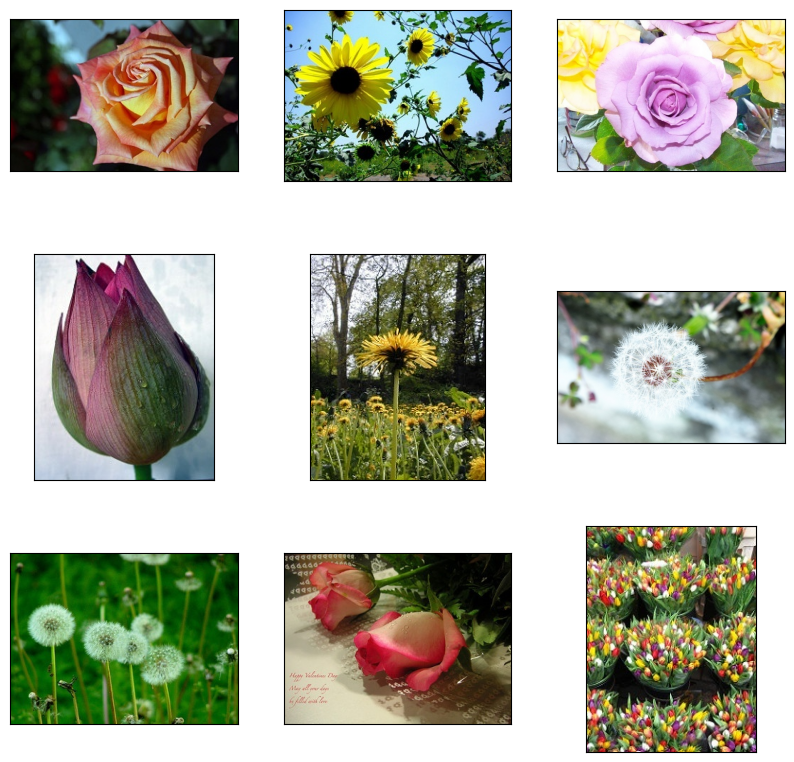

Bu klasörde toplam 924 tane resim vardır.


In [9]:
# Resim dosyalarını tutacak bir liste oluşturun
resim_dosyalari = []

for dosya_adi in os.listdir(test_dir):
    # Sadece resim uzantılı dosyaları al
    if dosya_adi.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Dosyanın tam yolunu listeye ekleme
        resim_dosyalari.append(os.path.join(test_dir, dosya_adi))
 
plt.figure(figsize=(10, 10))
for i in range(9):
    if i < len(resim_dosyalari): # Listede yeterli resim varsa çalışır
        plt.subplot(3, 3, i + 1)
        plt.xticks([]); plt.yticks([])
        plt.grid(False)

        # Resmi Pillow (PIL) kütüphanesi yardımı ile açma
        img = Image.open(resim_dosyalari[i])
        
        # Resmi matplotlib ile göster
        plt.imshow(img)

plt.show()
print(f"Bu klasörde toplam {len(resim_dosyalari)} tane resim vardır.")

# 3-VERİ SETİNİ AYIRMA

Güzel şimdi de Test ve Train verilerinin dağılımına bakıp Train veri setini Validasyon ve Train olacak şekilde ikiye ayırmalıyız. Ve ayırmadan önce nasıl bir dağılıma sahip olmaları gerek görmeliyiz.

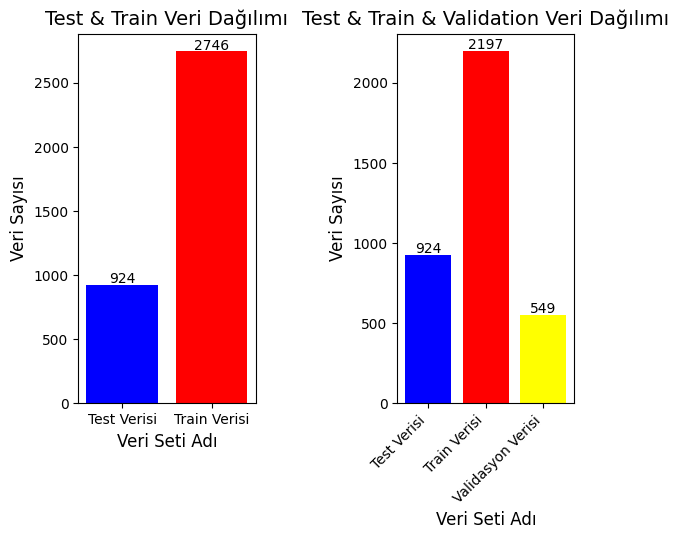

20181

In [10]:
dagilim1=[len(resim_dosyalari),count]
targets1=['Test Verisi','Train Verisi']

valid=(count*2)//10 #%20 validasyon için ayrılırsa

dagilim2=[len(resim_dosyalari),count-valid, valid]
targets2=['Test Verisi','Train Verisi','Validasyon Verisi']
plt.subplot(1,2,1)
# Çubuk grafiği oluşturma
plt.bar(targets1, dagilim1, color=['blue', 'red'])
plt.title('Test & Train Veri Dağılımı', fontsize=14)
plt.xlabel('Veri Seti Adı', fontsize=12)
plt.ylabel('Veri Sayısı', fontsize=12)

for i in range(len(targets1)):
    plt.text(i, dagilim1[i] + 15, dagilim1[i], ha='center')
    
plt.subplot(1,2,2)

# Çubuk grafiği oluşturma
plt.bar(targets2, dagilim2, color=['blue', 'red', 'yellow'])
plt.title('Test & Train & Validation Veri Dağılımı', fontsize=14)
plt.xlabel('Veri Seti Adı', fontsize=12)
plt.ylabel('Veri Sayısı', fontsize=12)
plt.xticks(rotation=45, ha='right')

for i in range(len(targets2)):
    plt.text(i, dagilim2[i] + 15, dagilim2[i], ha='center')

plt.subplots_adjust(wspace=0.8)

plt.show()

del dagilim1,dagilim2,targets1,targets2,valid
gc.collect()

Yukarıda da gördüğümüz gibi eğer train verisinin %20'sini validasyon için ayırırsak train için de güzel miktarda veri kalıyor. O halde şu aşamada model oluşturmaya başlamadan önce yapmamız gereken şey: Train veri setini bölmek.

resim_yollari = []
etiketler = []

veri_seti_klasoru = "/kaggle/input/flowers-dataset/train"

 #Ana klasör içindeki tüm alt klasörleri dolaş
for klasor_adi in os.listdir(veri_seti_klasoru):
    klasor_yolu = os.path.join(veri_seti_klasoru, klasor_adi)

    # Eğer bir alt klasör ise kontolü
    if os.path.isdir(klasor_yolu):
        for dosya_adi in os.listdir(klasor_yolu):
            # Dosya uzantısını kontrol et
            if dosya_adi.lower().endswith(('.png', '.jpg', '.jpeg')):
                tam_yol = os.path.join(klasor_yolu, dosya_adi)
                resim_yollari.append(tam_yol)
                etiketler.append(klasor_adi) # Klasör adı etiket olduğu için direkt append ettik.

In [11]:
# Veriyi %80 eğitim ve %20 doğrulama olarak ayır
X_train, X_valid, Y_train, Y_valid = train_test_split(
    X_train,Y_train,
    test_size=0.2,    # %20'si doğrulama verisi olacak
    random_state=42   # Verinin her seferinde aynı şekilde bölünmesini sağlar
)

X_test = get_testing_data(test_dir)

print(f"Toplam resim sayısı: {len(X_train)+len(X_valid)+len(X_test)}")
print(f"Eğitim seti boyutu: {len(X_train)}")
print(f"Doğrulama seti boyutu: {len(X_valid)}")
print(f"Test seti boyutu: {len(X_test)}")

100%|██████████| 924/924 [00:12<00:00, 75.47it/s]


Toplam resim sayısı: 3670
Eğitim seti boyutu: 2196
Doğrulama seti boyutu: 550
Test seti boyutu: 924


Böylece verilerimiz eğitime hazır hale geldi.

# 4-MODEL KURMA

## 1-Verileri Normalleştirme 
 Bu aşama, görsel verilerini numpy array haline çevirip değerlerini 0-255 den 0-1 arasına indirgemeyi kapsar. Böylece model daha kolay eğitilecektir. Biz bu işlemi verileri fonksiyonlar aracılığıyla yüklerken zaten yaptık bu nedenle bir sonraki aşama olan veri arttırımına geçebiliriz.

## 2-Veri Artırımı
Bu aşamada elimizde olan verileri döndürme, zoom yapma gibi metotlarda çoğaltacağız bu işlem modelin daha iyi eğitilmesine yardımcı olacaktır.

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,             
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    zca_whitening = True, # ZCA beyazlatma uygula
    vertical_flip = True # resimleri rastgele dikey çevir
)

datagen.fit(X_train)

/usr/local/lib/python3.11/dist-packages/keras/src/legacy/preprocessing/image.py:1047: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


## 3-Model Oluşturma
Bu aşamada verilerimizi CNN modeli içerisinde eğiteceğiz.

In [ ]:
# Rastgelelikleri sabitleme: Eğer seed belirtmezsek -> her çalıştırmada farklı sonuç çıkar.
def set_seed(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    # TensorFlow için deterministik seçenekler
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'


set_seed(123) #her çalıştırmada aynı değeri verir bize

batch_size = [16,32,64]
epochs_list = [10,20,25,30]
results={} #epoch sayısı ve batch size değişimine bağlı sonuçlar depolanacaktır

#Resimler ve labellarda farklılık olmasın diye yazıyoruz:
min_len = min(len(X_train), len(Y_train))
X_train = X_train[:min_len]
Y_train = Y_train[:min_len]


num_classes = 5  # sınıf sayısı
Y_train = to_categorical(Y_train, num_classes) #Keras’taki to_categorical fonksiyonu sınıf numaralarını vektöre çevirir
Y_valid = to_categorical(Y_valid, num_classes)

# EarlyStopping: validasyon loss 5 epoch boyunca düşmezse durdur
early_stop = EarlyStopping(
    monitor='val_loss',  # hangi metriğe bakacağını belirtiyoruz
    patience=5,          # kaç epoch bekleyeceği
    restore_best_weights=True  # en iyi performans gösterdiği epoch değerine geri al
)

# ReduceLROnPlateau: loss düşmezse öğrenme oranını azalt learning rate
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, #geliştirme durursa LR = LR * 0.2 olur.
    patience=3, #kac epoch başarı artmazsa devreye gireceğini belirler
    min_lr=1e-6
)

# Model mimarisini kurma
for batch in batch_size:
    for epoch in epochs_list:
        model = Sequential([
            Conv2D(16, (3,3), strides=1, padding="same",activation="relu", input_shape=(160,160,3)),
            BatchNormalization(),
            Activation("relu"),
            MaxPool2D((2,2), strides=2, padding="same"),

            Conv2D(32, (3,3), strides=1, padding="same", activation="relu"),
            BatchNormalization(),
            Activation("relu"),
            MaxPool2D((2,2), strides=2, padding="same"),

            Conv2D(64, (3,3), strides=1, padding="same", activation="relu"),
            BatchNormalization(),
            Activation("relu"),
            MaxPool2D((2,2), strides=2, padding="same"),

            Flatten(),
            Dense(128, activation="relu"),
            BatchNormalization(),
            Activation("relu"),
            Dropout(0.5),
            Dense(len(labels), activation='softmax')
        ])

        # Derleme
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
        model.summary()
        
        # Callbacks
        earlystop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
        
        # Eğitim
        history = model.fit(
            datagen.flow(X_train, Y_train, batch_size=batch),
            epochs=epoch,
            batch_size=batch,
            validation_data=datagen.flow(X_valid, Y_valid),
            callbacks=[reduce_lr, early_stop],
            verbose=1 #ilerlemeyi görsel olarak net görürüz
        )

        results[(batch, epoch)] = {
            'train_acc': history.history['accuracy'][-1],
            'val_acc': history.history['val_accuracy'][-1],
            'train_loss': history.history['loss'][-1],
            'val_loss': history.history['val_loss'][-1]
        }


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1758894360.627890      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758894360.629972      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 160, 160, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 160, 160, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 160, 160, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 80, 80, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 40, 40, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 40, 40, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,276,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,302,117 (12.60 MB)

 Trainable params: 3,301,637 (12.59 MB)

 Non-trainable params: 480 (1.88 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1758894416.533755     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


 17/138 ━━━━━━━━━━━━━━━━━━━━ 30:59 15s/step - accuracy: 0.1856 - loss: 0.8982

In [ ]:
for batch in batch_sizes:
    val_acc = [results[(batch, e)]['val_acc'] for e in epochs_list]
    plt.plot(epochs_list, val_acc, marker='o', label=f'batch_size={batch}')

plt.title("Validation Accuracy vs Epochs")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.show()